# [5-7] gamepadCtrl

USB 인터페이스가 있는 게임패드를 사용하면 JETANK를 제어할 수 있습니다.  
Jetbot에서 제공하는 원격 조작 예제와 달리 USB 리시버를 컴퓨터에 연결하는 대신 Jetson Nano의 USB 포트에 게임패드의 USB 리시버를 연결해야 합니다.

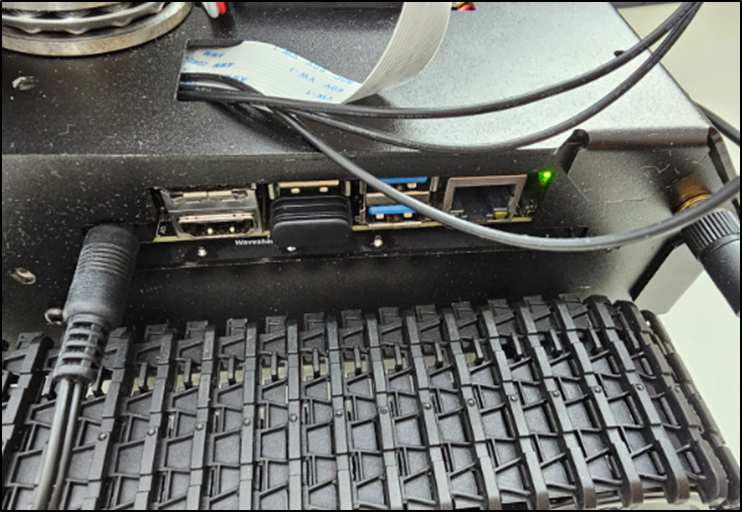  
USB 리시버를 Jetson Nano에 연결한 후에는 게임패드의 스위치를 켜고, 게임패드의 표시등이 켜진 후에 다음 코드를 실행하십시오.

## Importing the Camera class
  
다음 코드를 실행하여 카메라 위젯을 엽니다. 화면이 열리면 화면을 마우스 오른쪽 버튼으로 클릭하고 새로운 출력 보기 만들기를 선택한 다음 화면을 옆에 적합한 위치로 끌어놓을 수 있습니다.

In [1]:
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=300, height=300)
image = widgets.Image(format='jpeg', width=300, height=300) 
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

## Basic control
  
로봇 팔의 끝이 직선으로 이동하도록 보장하기 위해 역운동학 함수를 연속적으로 호출해야 하므로, 로봇 팔을 다중 스레드로 제어하기 위해 threading 라이브러리를 가져와야 합니다.

In [2]:
import threading
from time import sleep
from jetbot import Robot
from SCSCtrl import TTLServo

robot = Robot()

Succeeded to open the port
Succeeded to change the baudrate


기본 제어를 위해 몇 가지 변수와 매개변수를 정의합니다.

In [3]:
# 모터의 초기 회전 임계값입니다.
# 기어 모터는 낮은 PWM 간격에서 회전할 수 없습니다.
# 장기간의 정전은 모터의 수명을 줄일 수 있습니다.
moveStartTor = 0.15    

fb_input = 0           # 전방 및 후방 방향의 속도 매개변수를 저장합니다.
lr_input = 0           # 조향에 대한 매개변수를 저장합니다.

servoCtrlTime = 0.001   # TTL 서보 통신 후 오류를 피하기 위한 지연입니다.
speedInput = 300       # 카메라의 틸트 및 팬 회전 속도입니다.

armXStatus = 0         # 로봇 팔의 X 축 이동 상태 (원거리 및 근거리 방향)입니다.
armYStatus = 0         # 로봇 팔의 Y 축 이동 상태 (수직 방향)입니다.
cameStatus = 0         # 카메라의 이동 상태입니다.
goalX = 130            # 로봇 팔의 그리퍼의 X축 좌표를 저장하세요.
goalY = 50             # 로봇 팔의 그리퍼의 Y축 좌표를 저장하세요.
goalC = 0              # 카메라의 위치를 저장하세요.

xMax = 210             # 로봇 팔의 X 축 최대값을 설정하세요.
xMin = 140             # 로봇 팔의 X 축 최소값을 설정하세요.

yMax = 120             # 로봇 팔의 Y 축 최대값을 설정하세요.
yMix = -120            # 로봇 팔의 Y 축 최소값을 설정하세요.

cMax = 25              # 카메라의 최대 위치를 설정하세요.
cMin = -45             # 카메라의 최소 위치를 설정하세요.
cDan = 0               # 카메라의 위험한 선을 설정하세요.

movingTime = 0.005 # 로봇 팔 역운동학 함수의 인접한 두 위치 간의 실행 시간을 설정하세요.
movingSpeed = 1        # 로봇 팔의 이동 속도를 설정하세요.
grabStatus = 0         # 그리퍼의 이동 상태입니다.
cameraPosCheckMode = 1 # 카메라 위치 확인 기능의 스위치, 1 - 켜기, 0 - 끄기입니다.
                       # 한 번 켜면, 로봇 팔과 카메라 간의 간섭을 피할 수 있습니다.
cameraPosDanger = 0    # 카메라가 위험 지역에 있는지 여부입니다.
cameraMoveSafe = 0     # 카메라가 안전 지역으로 이동했는지 여부입니다.

아래 코드를 실행한 후, 로봇 팔이 자동으로 위치(goalX, goalY)로 이동하고, 나머지 서보들이 초기 위치로 천천히 회전합니다.
> 주의사항 : 
'[5-2] JETANK_1_servos.ipynb' 에서 살펴보았듯이 서보 모터의 조립 방향에 따라 각도가 다를 수 있습니다.

In [4]:
TTLServo.xyInputSmooth(goalX, goalY, 3)
TTLServo.servoAngleCtrl(1, 0, 1, 100)
TTLServo.servoAngleCtrl(4, 0, 1, 100)
TTLServo.servoAngleCtrl(5, 0, 1, 100)
sleep(3.5)
print('ready!')

ready!


일부 기본 운동 기능을 정의합니다.

In [5]:
# 로봇 팔이 현재 작업을 중지합니다.
def armStop():
    global armXStatus, armYStatus
    if armXStatus or armYStatus:
        armXStatus = 0
        armYStatus = 0
        TTLServo.servoStop(2)
        sleep(servoCtrlTime)
        TTLServo.servoStop(3)
        sleep(servoCtrlTime)
        print([goalX, goalY])

# 카메라 위치 확인 및 보호 기능입니다.
def armCameraPosCheck():
    global cameraPosDanger, cameraMoveSafe, goalC
    if goalY < -50 and cameraPosCheckMode:
        cameraPosDanger = 1
        if cameraMoveSafe and goalC < cDan:
            goalC = cDan
            TTLServo.servoAngleCtrl(5, cDan, 1, speedInput)
            sleep(servoCtrlTime)
            cameraMoveSafe = 0
    else:
        cameraPosDanger = 0

# 그리퍼의 잡기 및 풀기를 제어합니다.
def grabCtrlCommand(commandType, valueInput):
    global grabStatus
    if commandType == 'tl':
        commandLoose = 0
        if valueInput:
            commandGrab = 1
        else:
            commandGrab = 0
    elif commandType == 'tl2':
        commandGrab = 0
        if valueInput:
            commandLoose = 1
        else:
            commandLoose = 0
    else:
        return

    if commandGrab and not grabStatus:
        TTLServo.servoAngleCtrl(4, -90, 1, 150)
        grabStatus = 1
        sleep(servoCtrlTime)
    elif commandLoose and not grabStatus:
        TTLServo.servoAngleCtrl(4, 0, 1, 150)
        grabStatus = 1
        sleep(servoCtrlTime)

    if not commandGrab and not commandLoose and grabStatus:
        TTLServo.servoStop(4)
        grabStatus = 0
        sleep(servoCtrlTime)

# 로봇 팔 제어 함수, 명령 입력용입니다.
def armCtrlCommand(commandType, valueInput):
    global xMax, xMin, yMax, yMix, goalX, goalY, armXStatus, armYStatus
    commandXin, commandXde, commandYin, commandYde = 0, 0, 0, 0
    if commandType == 'y':
        if valueInput:
            ctrlArm.moveXin = 1
            ctrlArm.resume()
            print('run')
        else:
            ctrlArm.moveXin = 0
            ctrlArm.pause()
    elif commandType == 'a':
        if valueInput:
            ctrlArm.moveXde = 1
            ctrlArm.resume()
        else:
            ctrlArm.moveXde = 0
            ctrlArm.resume()
    elif commandType == 'tr':
        if valueInput:
            ctrlArm.moveYin = 1
            ctrlArm.resume()
        else:
            ctrlArm.moveYin = 0
            ctrlArm.resume()
    elif commandType == 'tr2':
        if valueInput:
            ctrlArm.moveYde = 1
            ctrlArm.resume()
        else:
            ctrlArm.moveYde = 0
            ctrlArm.resume()
    else:
        return


# 로봇 팔 제어 함수, 동작 실행용 (다른 단일 스레드에서).
def armCtrl(commandXin, commandXde, commandYin, commandYde):
    global xMax, xMin, yMax, yMix, goalX, goalY, armXStatus, armYStatus, cameraMoveSafe
    armCameraPosCheck()
    if commandXin:
        armXStatus = 1
        goalX += movingSpeed
        if goalX > xMax:
            goalX = xMax
        TTLServo.xyInputSmooth(goalX, goalY, movingTime)
        sleep(servoCtrlTime)
        return

    elif commandXde:
        armXStatus = 1
        goalX -= movingSpeed
        if goalX < xMin:
            goalX = xMin
        TTLServo.xyInputSmooth(goalX, goalY, movingTime)
        sleep(servoCtrlTime)
        return

    if commandYin:
        armYStatus = 1
        goalY += movingSpeed
        if goalY > yMax:
            goalY = yMax
        if goalY > -50:
            cameraMoveSafe = 1
        TTLServo.xyInputSmooth(goalX, goalY, movingTime)
        sleep(servoCtrlTime)
        return

    elif commandYde:
        armYStatus = 1
        goalY -= movingSpeed
        if goalY < yMix:
            goalY = yMix
        if goalY > -50:
            cameraMoveSafe = 1
        TTLServo.xyInputSmooth(goalX, goalY, movingTime)
        sleep(servoCtrlTime)
        return

    if not commandXin and not commandXde and not commandYin and not commandYde:
        armStop()


# 카메라의 틸팅 동작이 중지 함수입니다
def tiltStop():
    global cameStatus
    cameStatus = 0
    TTLServo.servoStop(5)
    sleep(servoCtrlTime)

# 카메라(로봇 팔)가 팬 방향으로의 이동 중지 함수입니다.
def panStop():
    TTLServo.servoStop(1)
    sleep(servoCtrlTime)

# 카메라 틸트 동작 제어 (다른 단일 스레드에서)
def cameraTiltCtrl(commandCin, commandCde):
    global goalC, cameStatus
    if commandCde:
        cameStatus = 1
        if not cameraPosDanger:
            goalC -= movingSpeed
            if goalC < cMin:
                goalC = cMin
            TTLServo.servoAngleCtrl(5, goalC, 1, speedInput)
            sleep(servoCtrlTime)
        else:
            goalC -= movingSpeed
            if goalC < cDan:
                goalC = cDan
            TTLServo.servoAngleCtrl(5, goalC, 1, speedInput)
            sleep(servoCtrlTime)
        return
    if commandCin:
        cameStatus = 1
        goalC += movingSpeed
        if goalC > cMax:
            goalC = cMax
        TTLServo.servoAngleCtrl(5, goalC, 1, speedInput)
        sleep(servoCtrlTime)
        return
    if not commandCde and not commandCin:
        tiltStop()
            
# 카메라(로봇 팔)의 팬 회전 제어.
def cameraPanCtrlCommand(commandType, valueInput, buttonLoop):
    commandLeft, commandRight = 0, 0
    if commandType == 'lr' and buttonLoop:
        if valueInput == -1:
            commandLeft = 1
        elif valueInput == 1:
            commandRight = 1
    elif commandType == 'x' and not buttonLoop:
        if valueInput:
            commandLeft = 1
    elif commandType == 'b' and not buttonLoop:
        if valueInput:
            commandRight = 1
    else:
        return

    if commandLeft:
        TTLServo.servoAngleCtrl(1, -80, 1, speedInput)
        sleep(servoCtrlTime)
    elif commandRight:
        TTLServo.servoAngleCtrl(1, 80, 1, speedInput)
        sleep(servoCtrlTime)
    elif not commandLeft and not commandRight:
        panStop()

# 카메라의 틸트 모션 제어.
def cameraTiltCtrlCommand(commandType, valueInput):
    commandUp, commandDown = 0, 0
    if commandType == 'fb':
        if valueInput == -1:
            commandUp = 1
        elif valueInput == 1:
            commandDown = 1
    else:
        return

    if commandUp:
        ctrlArm.moveCde = 1
        ctrlArm.moveCin = 0
        ctrlArm.resume()
    elif commandDown:
        ctrlArm.moveCin = 1
        ctrlArm.moveCde = 0
        ctrlArm.resume()
    else:
        ctrlArm.moveCin = 0
        ctrlArm.moveCde = 0
        ctrlArm.resume()
# AGV의 이동이 멈춥니다.
def moveStop():
    global fb_input, lr_input
    fb_input = 0
    lr_input = 0
    robot.stop()

# AGV의 이동을 제어합니다.
def moveSmoothCtrl(commandType, valueInput):
    global fb_input, lr_input
    if commandType == 'y':
        fb_input = valueInput
    elif commandType == 'x':
        lr_input = valueInput
    else:
        return

    if abs(fb_input) < moveStartTor and abs(lr_input) < moveStartTor:
        moveStop()
        return
    leftSpeed  = -fb_input + lr_input
    rightSpeed = -fb_input - lr_input
    robot.left_motor.value  = leftSpeed
    robot.right_motor.value = rightSpeed



로봇 팔을 다중 스레드로 제어하는 class를 선언하고 객체 생성합니다.


In [6]:
# 로봇 팔의 다중 스레드 제어 객체는 인스턴스화된 후에 pause()와 resume()를 호출하여 run()의 일시 중지 및 재개를 제어합니다.
class ArmCtrlThread(threading.Thread):
    def __init__(self, *args, **kwargs):
        super(ArmCtrlThread, self).__init__(*args, **kwargs)
        self.__flag = threading.Event()
        self.__flag.clear()
        self.moveXin = 0
        self.moveXde = 0
        self.moveYin = 0
        self.moveYde = 0
        self.moveCin = 0
        self.moveCde = 0

    def pause(self):
        self.__flag.clear()

    def resume(self):
        self.__flag.set()

    def run(self):
        while 1:
            self.__flag.wait()
            armCtrl(self.moveXin, self.moveXde, self.moveYin, self.moveYde)
            if self.moveCin or self.moveCde:
                cameraTiltCtrl(self.moveCin, self.moveCde)
            if not self.moveXin and not self.moveXde and not self.moveYin and not self.moveYde and not self.moveCin and not self.moveCde:
                self.pause()
            sleep(movingTime)


#다중 스레드 서보 제어 스레드를 인스턴스화하고 시작합니다
ctrlArm = ArmCtrlThread()
ctrlArm.start()

게임 패드 기본 동작

> 주의  
아래 코드를 실행하기 전에 먼저 게임패드에 AA 건전지를 넣고, 전원을 켠다.  
전원을 켜면 아래 사진과 같이 게임패드에 불이 들어온다.  
코드를 동작시키면 AGV가 앞으로 움직이는 데, 조이스틱의 박스친 부분을 위아래로 움직여서 움직임을 제어한다.

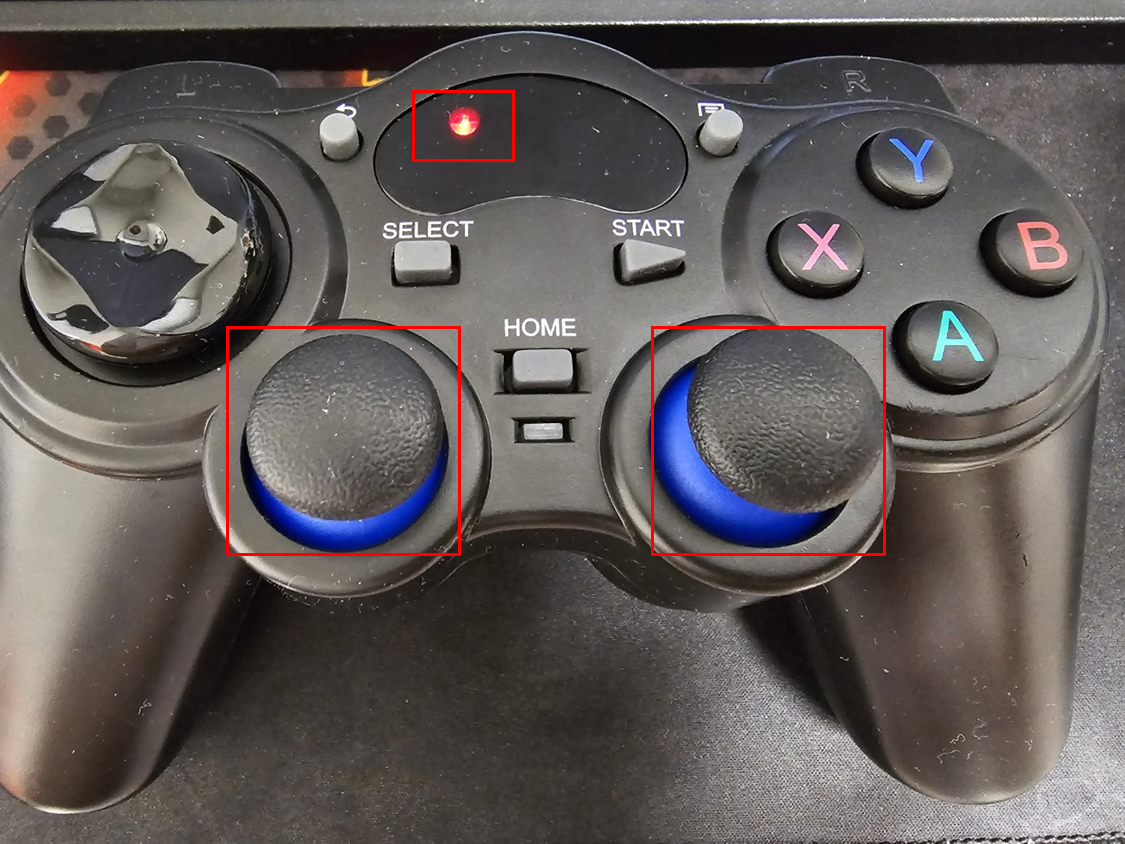

In [7]:
import os, struct, array
from fcntl import ioctl
 
# 조이스틱 장치를 반복합니다.
print('Available devices:')
for fn in os.listdir('/dev/input'):
    if fn.startswith('js'):
        print('  /dev/input/%s' % (fn))
 
 
# 이러한 상수들은 linux/input.h에서 가져왔습니다.
axis_names = {
    0x00 : 'x',
    0x01 : 'y',
    0x02 : 'z',
    0x03 : 'rx',
    0x04 : 'ry',
    0x05 : 'rz',
    0x06 : 'trottle',
    0x07 : 'rudder',
    0x08 : 'wheel',
    0x09 : 'gas',
    0x0a : 'brake',
    0x10 : 'lr',
    0x11 : 'fb',
    0x12 : 'hat1x',
    0x13 : 'hat1y',
    0x14 : 'hat2x',
    0x15 : 'hat2y',
    0x16 : 'hat3x',
    0x17 : 'hat3y',
    0x18 : 'pressure',
    0x19 : 'distance',
    0x1a : 'tilt_x',
    0x1b : 'tilt_y',
    0x1c : 'tool_width',
    0x20 : 'volume',
    0x28 : 'misc',
}
 
button_names = {
    0x120 : 'trigger',
    0x121 : 'thumb',
    0x122 : 'thumb2',
    0x123 : 'top',
    0x124 : 'top2',
    0x125 : 'pinkie',
    0x126 : 'base',
    0x127 : 'base2',
    0x128 : 'base3',
    0x129 : 'base4',
    0x12a : 'base5',
    0x12b : 'base6',
    0x12f : 'dead',
    0x130 : 'a',
    0x131 : 'b',
    0x132 : 'c',
    0x133 : 'x',
    0x134 : 'y',
    0x135 : 'z',
    0x136 : 'tl',
    0x137 : 'tr',
    0x138 : 'tl2',
    0x139 : 'tr2',
    0x13a : 'select',
    0x13b : 'start',
    0x13c : 'mode',
    0x13d : 'thumbl',
    0x13e : 'thumbr',
 
    0x220 : 'dpad_up',
    0x221 : 'dpad_down',
    0x222 : 'dpad_left',
    0x223 : 'dpad_right',
 
    0x2c0 : 'dpad_left',
    0x2c1 : 'dpad_right',
    0x2c2 : 'dpad_up',
    0x2c3 : 'dpad_down',
}
 
axis_map = []
button_map = []
 
# 조이스틱 장치를 엽니다.
fn = '/dev/input/js0'
print('Opening %s...' % fn)
jsdev = open(fn, 'rb')
 
# 장치 이름을 가져옵니다.
buf = array.array('B', [0] * 64)
ioctl(jsdev, 0x80006a13 + (0x10000 * len(buf)), buf) 
# JSIOCGNAME(len)
js_name = buf.tobytes().rstrip(b'\x00').decode('utf-8')
print('Device name: %s' % js_name)
 
# 축과 버튼의 수를 가져옵니다.
buf = array.array('B', [0])
ioctl(jsdev, 0x80016a11, buf)
num_axes = buf[0]
 
buf = array.array('B', [0])
ioctl(jsdev, 0x80016a12, buf)
num_buttons = buf[0]
 
# 조이스틱 주소를 가져와서 axis_names에 있는 이름과 대응합니다.
buf = array.array('B', [0] * 0x40)
ioctl(jsdev, 0x80406a32, buf) # JSIOCGAXMAP
 
for axis in buf[:num_axes]:
    axis_name = axis_names.get(axis, 'unknown(0x%02x)' % axis)
    axis_map.append(axis_name)

# 버튼 주소를 가져와서 button_names에 있는 이름과 대응합니다.
buf = array.array('H', [0] * 200)
ioctl(jsdev, 0x80406a34, buf) # JSIOCGBTNMAP
 
for btn in buf[:num_buttons]:
    btn_name = button_names.get(btn, 'unknown(0x%03x)' % btn)
    button_map.append(btn_name)

print('%d axes found: %s' % (num_axes, ', '.join(axis_map)))
print('%d buttons found: %s' % (num_buttons, ', '.join(button_map)))
 

# 게임패드 변경 정보를 읽고 AGV을 제어합니다.
class inputThread(threading.Thread):
    def __init__(self, *args, **kwargs):
        super(inputThread, self).__init__(*args, **kwargs)
        self.__flag = threading.Event()
        self.__flag.clear()

    def pause(self):
        self.__flag.clear()

    def resume(self):
        self.__flag.set()

    def run(self):
        while 1:
            self.__flag.wait()
            evbuf = jsdev.read(8)
            if evbuf:
                time, value, type, number = struct.unpack('IhBB', evbuf)

                if type & 0x80:
                     print("(initial)", end="")

                if type & 0x01:
                    button = button_map[number]
                    if button:
                        grabCtrlCommand(button, value)
                        armCtrlCommand(button, value)
                        cameraPanCtrlCommand(button, value, 0)

                if type & 0x02:
                    axis = axis_map[number]
                    if axis:
                        moveSmoothCtrl(axis, value/32767.0)
                        cameraPanCtrlCommand(axis, int(round(value/32767.0,0)), 1)
                        cameraTiltCtrlCommand(axis, int(round(value/32767.0,0)))


# 게임패드 입력 스레드를 인스턴스화하고 정보를 읽기 시작합니다.
inputThreading = inputThread()
inputThreading.start()
inputThreading.resume()


Available devices:
  /dev/input/js0
Opening /dev/input/js0...
Device name: SHANWAN Android Gamepad
8 axes found: x, y, z, rz, gas, brake, lr, fb
16 buttons found: a, b, c, x, y, z, tl, tr, tl2, tr2, select, start, mode, thumbl, thumbr, unknown(0x13f)
(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)(initial)

게임 패드로 AGV를 제어 할 수 있습니다.

## Key Description

L1 버튼: 그리퍼가 잡기 시작합니다.  
L2 버튼: 그리퍼가 풀기 시작합니다.  
A/B/X/Y 버튼: 로봇 팔의 끝이 뒤로 이동/카메라가 오른쪽을 볼 때/카메라가 왼쪽을 볼 때/로봇 팔의 끝이 앞으로 이동합니다.  
왼쪽 조이스틱: 로봇의 전진 및 후진 이동 및 조향을 제어합니다.  
왼쪽 방향 버튼 (위): 카메라를 위로 올립니다.  
왼쪽 방향 버튼 (아래): 카메라를 아래로 내립니다.  
왼쪽 방향 버튼 (왼쪽): 카메라를 왼쪽으로 이동합니다.  
왼쪽 방향 버튼 (오른쪽): 카메라를 오른쪽으로 이동합니다.  
R1 버튼: 로봇 팔의 끝이 수직 방향으로 위로 이동합니다.  
R2 버튼: 로봇 팔의 끝이 수직 방향으로 아래로 이동합니다.  

## 프로젝트 종료하기
프로젝트를 종료할 때는 꼭 robot과 camera를 종료한다.

In [ ]:
robot.stop()
camera.stop()